# Loading and Preprocessing Data with TensorFlow

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

2024-01-11 21:38:30.312578: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-11 21:38:30.353650: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-11 21:38:30.354069: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-11 21:38:31.353767: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## The Data API

The whole Data api revolves around the concept of *datasets*. Usually, we will use datasets that gradually read data from disk, but from simplicity let's create a dataset entirely in RAM using `tf.data.Dataset.from_tensor_slices()`:

In [14]:
X = tf.range(10) # any data tensor
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>

The `from_tensor_slices()` function takes a tensor and creates a `tf.data.Dataset` whose elements are all slices of `X` (along the first dimension), so this dataset contains 10 items: tensors 0, 1, 2,...,9. In this case we would have obtained the same dataset if we had used `tf.data.Dataset.range(10)`

We can simply iterate over a dataset's items like this:

In [15]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


### Chaining Transformations

Once we have dataset, we can apply all sort of transformations to it by calling its transformation methods. Each method returns a new dataset, so we can chain transformations like this:

In [16]:
dataset = dataset.repeat(3).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


In this example, we first call `repeat()` method on the original dataset, and it returns a new dataset that will repeat the items in the original dataset three times. Then we call the `batch()` method on this new dataset, and again creates a new dataset. This one will group the items of the previous dataset in batches of seven items. Finally, we can iterate over the items of this final dataset.

As we can see, the `batch()` method had to output a final batch of size two instead of seven, but we can call it with a `drop_remainder=True` if we want it to drop this final batch so that all batches have the exact same size. 

We can also transform the items by calling the `map()` method. For ex., this creates a new dataset with all items doubled:

In [17]:
dataset = dataset.map(lambda x: x*2)
for item in dataset:
    print(item)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int32)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)
tf.Tensor([16 18], shape=(2,), dtype=int32)


This function is the one we will call to apply any preprocessing we want to our data. Sometimes this will include computations that can be quite intensive, such as reshaping or rotating an image, so we will usually want to spawn multiple threads to speed things up: it's as simple as setting the
`num_parallel_calls` argument. 

**NOTE**:
The function we pass to the `map()` must be convertible to TF Function

While `map()` method applies transformation to each item, the `apply()` method applies a transformation to the dataset as a whole. 

For ex., the `unbatch()` function to the dataset will create a new dataset where each item will be single-integer tensor instead of batch of seven integers:

In [18]:
dataset = dataset.unbatch()
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(12, shape=(), dtype=int32)
tf.Tensor(14, shape=(), dtype=int32)
tf.Tensor(16, shape=(), dtype=int32)
tf.Tensor(18, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(12, shape=(), dtype=int32)
tf.Tensor(14, shape=(), dtype=int32)
tf.Tensor(16, shape=(), dtype=int32)
tf.Tensor(18, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(12, shape=(), dtype=int32)
tf.Tensor(14, sh

It is also possible to simply filter the dataset using the `filter()` method:

In [19]:
dataset = dataset.filter(lambda x: x < 10)
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)


We will often want to look at just few items from a dataset. We can use `take()` method for that:

In [20]:
for item in dataset.take(3):
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)


### Shuffling the Data

Gradient Descent works best when the instances in the training set are independent and identically distributed. A simple way to ensure this is to shuffle the instances using the `shuffle()` method.  For ex:

In [21]:
dataset = tf.data.Dataset.range(10).repeat(3) # 0 to 9, 3 times
dataset = dataset.shuffle(buffer_size=5, seed=42).batch(7) # we must specify the buffer size, and it is imp to make it large enough, or else shuffling will not be very effective. 
for item in dataset:
    print(item)

tf.Tensor([0 2 3 6 7 9 4], shape=(7,), dtype=int64)
tf.Tensor([5 0 1 1 8 6 5], shape=(7,), dtype=int64)
tf.Tensor([4 8 7 1 2 3 0], shape=(7,), dtype=int64)
tf.Tensor([5 4 2 7 8 9 9], shape=(7,), dtype=int64)
tf.Tensor([3 6], shape=(2,), dtype=int64)


**TIP:**

If we call `repeat()` on a shuffled dataset, by default it will generate a new order at every iteration.

For large datasets that does not fit in memory, this simple shuffling-buffer approach may not be sufficient, since the buffer will be small compared to dataset. One solution is to shuffle the source data itself. This will definitely improve the shuffling a lot. Even if the data is shuffled, we usually want to shuffle it more. To shuffle the instances some more, a common approach is to split source data into multiple files, then read them in random order during training. However, instances located in same file will still end up close together. To avoid this, we can pick multiple files randomly and read them simultaneously, interleaving records. Then on top of that we can add a shuffling buffer using `shuffle()` method. Let's see how it works:

Let's start by loading and preparing California dataset. We will first load it, split it intro training, validation and test set and finally we scale it.

In [22]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data,
                                                              housing.target.reshape(-1,1),
                                                             random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_mean = scaler.mean_
X_std = scaler.scale_

For very large dataset that does not fit in memory, we will typically need to split it into many files first, then have TF read these files in parallel. To demonstrate this, let's start by splitting the housing dataset and save it in 20 csv files:

In [3]:
def save_to_multiple_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = os.path.join(os.curdir, "datasets", "california_housing")
    # print(housing_dir)
    os.makedirs(housing_dir, exist_ok=True)
    path_format = os.path.join(housing_dir, "my_{}_{:02d}.csv")
    
    file_paths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        file_paths.append(part_csv)
        with open (part_csv, "wt", encoding="utf-8") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                """
                Python repr() function returns a printable representation of the object by converting
                that object to a string.
                """
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return file_paths

In [4]:
train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_multiple_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_multiple_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_multiple_files(test_data, "test", header, n_parts=10)

In [5]:
train_filepaths

['./datasets/california_housing/my_train_00.csv',
 './datasets/california_housing/my_train_01.csv',
 './datasets/california_housing/my_train_02.csv',
 './datasets/california_housing/my_train_03.csv',
 './datasets/california_housing/my_train_04.csv',
 './datasets/california_housing/my_train_05.csv',
 './datasets/california_housing/my_train_06.csv',
 './datasets/california_housing/my_train_07.csv',
 './datasets/california_housing/my_train_08.csv',
 './datasets/california_housing/my_train_09.csv',
 './datasets/california_housing/my_train_10.csv',
 './datasets/california_housing/my_train_11.csv',
 './datasets/california_housing/my_train_12.csv',
 './datasets/california_housing/my_train_13.csv',
 './datasets/california_housing/my_train_14.csv',
 './datasets/california_housing/my_train_15.csv',
 './datasets/california_housing/my_train_16.csv',
 './datasets/california_housing/my_train_17.csv',
 './datasets/california_housing/my_train_18.csv',
 './datasets/california_housing/my_train_19.csv']

Okay, now let's look at the first few lines of one of these csv files:

In [48]:
pd.read_csv(train_filepaths[0]).head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
0,3.5214,15.0,3.049945,1.106548,1447.0,1.605993,37.63,-122.43,1.442
1,5.3275,5.0,6.490060,0.991054,3464.0,3.443340,33.69,-117.39,1.687
2,3.1000,29.0,7.542373,1.591525,1328.0,2.250847,38.44,-122.98,1.621
3,7.1736,12.0,6.289003,0.997442,1054.0,2.695652,33.55,-117.70,2.621
4,2.0549,13.0,5.312457,1.085092,3297.0,2.244384,33.93,-116.93,0.956


Or in text mode:

In [51]:
with open(train_filepaths[0]) as f:
    for i in range(5):
        print(f.readline(), end="")

MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442
5.3275,5.0,6.490059642147117,0.9910536779324056,3464.0,3.4433399602385686,33.69,-117.39,1.687
3.1,29.0,7.5423728813559325,1.5915254237288134,1328.0,2.2508474576271187,38.44,-122.98,1.621
7.1736,12.0,6.289002557544757,0.9974424552429667,1054.0,2.6956521739130435,33.55,-117.7,2.621


#### Interleaving lines from multiple files

Now let's create a dataset containing only these train file paths:

In [54]:
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)

By defult `list_files()` returns a dataset that shuffles the file paths. In general this is good, but we can set `shuffle=False` if we do not want that for some reason.

Now we can call the `interleave()` method to read from five files at a time and interleave thier lines (skipping the first line of each file, which is header row, using the `skip()` method):

In [56]:
for filepath in filepath_dataset:
    print(filepath)

tf.Tensor(b'./datasets/california_housing/my_train_05.csv', shape=(), dtype=string)
tf.Tensor(b'./datasets/california_housing/my_train_16.csv', shape=(), dtype=string)
tf.Tensor(b'./datasets/california_housing/my_train_01.csv', shape=(), dtype=string)
tf.Tensor(b'./datasets/california_housing/my_train_17.csv', shape=(), dtype=string)
tf.Tensor(b'./datasets/california_housing/my_train_00.csv', shape=(), dtype=string)
tf.Tensor(b'./datasets/california_housing/my_train_14.csv', shape=(), dtype=string)
tf.Tensor(b'./datasets/california_housing/my_train_10.csv', shape=(), dtype=string)
tf.Tensor(b'./datasets/california_housing/my_train_02.csv', shape=(), dtype=string)
tf.Tensor(b'./datasets/california_housing/my_train_12.csv', shape=(), dtype=string)
tf.Tensor(b'./datasets/california_housing/my_train_19.csv', shape=(), dtype=string)
tf.Tensor(b'./datasets/california_housing/my_train_07.csv', shape=(), dtype=string)
tf.Tensor(b'./datasets/california_housing/my_train_09.csv', shape=(), dtype=

In [55]:
n_readers = 5
"""
The tf.data.TextLineDataset loads text from text files and creates a dataset where each line of the files becomes an element of the dataset.
"""
dataset = filepath_dataset.interleave(lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
                                  cycle_length=n_readers)

The `interleave()` method will create a dataset that will pull five file path from the `filepath_dataset`, and for each one it will call the function we gave it (a lambda in this example), to create a new dataset (in this case a `TextLineDataset`). 

To be clear, at this stage there will be seven datasets in all: the filepath dataset, the interleave dataset, and the five `TextLineDataset` created internally by the interleave dataset. When we interate over the interleave dataset, it will cycle through these five `TextLineDatasets`, reading one line at a time from each until all datasets are out of items. Then it will get next five file paths from the `filepath_datasets` and interleave them the same way, and so on until it runs out of file paths. 

**TIP:**

For interleaving to work best, it is preferable to have files of identical lengths; otherwise the ends of the longest files will not be interleaved.

By default, `interleave()` does not use parallelism; it just reads one line at a time from each line, sequentially. If we want it to actually read files in parallel, we can set the `num_parallel_calls` argument to the number of threads we want. We can even set  it to `tf.data.AUTOTUNE` to make tf choose the right number of threads dynamically based on the available CPU. 

Let's look at what the dataset contains now:

In [60]:
for line in dataset.take(5):
    print(line.numpy())

b'4.1812,52.0,5.701388888888889,0.9965277777777778,692.0,2.4027777777777777,33.73,-118.31,3.215'
b'3.226,52.0,5.372469635627531,0.9473684210526315,1157.0,2.3421052631578947,37.96,-121.31,1.076'
b'4.2708,45.0,5.121387283236994,0.953757225433526,492.0,2.8439306358381504,37.48,-122.19,2.67'
b'3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442'
b'3.0217,22.0,4.983870967741935,1.1008064516129032,615.0,2.4798387096774195,38.76,-120.6,1.069'


Looks good! But as we can see, these are just byte strings; we need to parse them and scale the data.

In [63]:
record_defaults = [0, np.nan, tf.constant(np.nan, dtype=np.float64), "Hello", tf.constant([])]
"""
tf.io.decode_csv : Convert CSV records to tensors. Each column maps to one tensor.

record_defaults = A list of Tensor objects with specific types. 
"""
parsed_fields = tf.io.decode_csv("1,2,3,4,5", record_defaults)
parsed_fields

[<tf.Tensor: shape=(), dtype=int32, numpy=1>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.0>,
 <tf.Tensor: shape=(), dtype=float64, numpy=3.0>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'4'>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5.0>]

Notice that in above, field 4 is interpreted as string.

In [64]:
parsed_fields = tf.io.decode_csv(",,,,5", record_defaults)
parsed_fields

[<tf.Tensor: shape=(), dtype=int32, numpy=0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=nan>,
 <tf.Tensor: shape=(), dtype=float64, numpy=nan>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'Hello'>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5.0>]

Notice that all the missing values are replaced by default values.

Also the number of fields should match exactly the number of fields in record_defaults

### Preprocessing the Data

Now let's implement a function that perfroms this preprocessing (parsing the csv and scaling them):

In [9]:
n_inputs = X_train.shape[-1]

def preprocess(line):
    defaults = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defaults)
    # print(fields)
    # fields is a list of tensors where each tensor contains one feature value. So we need to use tf.stack to make it to array
    x = tf.stack(fields[:-1])
    # print(x)
    y = tf.stack(fields[-1:])
    return (x-X_mean) / X_std, y

In [89]:
preprocess(b'4.1812,52.0,5.701388888888889,0.9965277777777778,692.0,2.4027777777777777,33.73, -118.31,3.215')

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([ 0.15159765,  1.8491895 ,  0.09624147, -0.22151624, -0.66828614,
        -0.23549314, -0.89780813,  0.6368871 ], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([3.215], dtype=float32)>)

Looks good! We can now apply the function to the dataset.

### Putting EveryThing Together

To make the code reusable, let's put together everything in small helper function: it will create and return a dataset that will efficiently load California housing dataset from multiple CSV files, preprocess it, shuffle it and optionally repeat it, and batch it.

In [7]:
def csv_reader_dataset(filepaths, repeat=1, n_readers=5, n_read_threads=None,
                       shuffle_buffer_size=10000, n_parse_threads=5, batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths).repeat(repeat)
    dataset = dataset.interleave(lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
                                cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    return dataset.batch(batch_size).prefetch(1)

The last line `prefetch(1)` is important for performance. 

### Prefetching

By calling `prefetch(1)` at the end, we are creating a dataset that will do its best to always be one batch ahead. (In general prefetching one batch is fine, but in some case we may need few more. We can always let tf decide on its own by passign `tf.data.AUTOTUNE`). In other words, while our training algorithm is working on one batch, the dataset will already be working in parallel on getting the next batch ready (e.g., reading the data from disk and preprocessing it). This can improve performace dramatically. If we also ensure that loading and preprocessing are multithreaded, we can exploit multiple cores on the CPU. 

If dataset is small enough to fit in memory, we can significantly speed up training by using the dataset's `cache()` method to cache its content to RAM. We should generally do this after loading and preprocessing data, but before shuffling, repeating, batching and prefetching. This way, each instance will only be read and preprocessed once (instead once per epoch), but the data will still be shuffled differently at each epoch, and the next batch will still be prepared in advance. 

### Using the Dataset with tf.keras

Now we have `csv_reader_dataset()` function to create a dataset for the training set.

In [10]:
tf.random.set_seed(42)

train_set = csv_reader_dataset(train_filepaths, batch_size=3)
for X_batch, y_batch in train_set.take(3):
    print("X =", X_batch)
    print("y =", y_batch)
    print()

X = tf.Tensor(
[[ 0.5804519  -0.20762321  0.05616303 -0.15191229  0.01343246  0.00604472
   1.2525111  -1.3671792 ]
 [ 5.818099    1.8491895   1.1784915   0.28173092 -1.2496178  -0.3571987
   0.7231292  -1.0023477 ]
 [-0.9253566   0.5834586  -0.7807257  -0.28213993 -0.36530012  0.27389365
  -0.76194876  0.72684526]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[1.752]
 [1.313]
 [1.535]], shape=(3, 1), dtype=float32)

X = tf.Tensor(
[[-0.8324941   0.6625668  -0.20741376 -0.18699841 -0.14536144  0.09635526
   0.9807942  -0.67250353]
 [-0.62183803  0.5834586  -0.19862501 -0.3500319  -1.1437552  -0.3363751
   1.107282   -0.8674123 ]
 [ 0.8683102   0.02970133  0.3427381  -0.29872298  0.7124906   0.28026953
  -0.72915536  0.86178064]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[0.919]
 [1.028]
 [2.182]], shape=(3, 1), dtype=float32)

X = tf.Tensor(
[[-1.0344558   1.0581076  -0.8869343  -0.08743899  0.6157541   0.4368748
  -0.75726473  0.64688075]
 [ 0.4675818   0.6625668   0.03120424 -0.

In [11]:
train_set = csv_reader_dataset(train_filepaths, repeat=None)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

And now we can simply build and train a Keras model using these datasets (support is specific for `tf.keras`). All we need to do is pass the training and validation datasets to the `fit()` method, instead of `X_train, y_train, X_vaild` and `y_valid`

In [12]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])

In [13]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [14]:
batch_size=32
model.fit(train_set, steps_per_epoch=len(X_train)//batch_size, epochs=10,
         validation_data=valid_set)

Epoch 1/10
362/362 [==============================] - 1s 3ms/step - loss: 2.0315 - val_loss: 3.7452
Epoch 2/10
362/362 [==============================] - 1s 3ms/step - loss: 0.9367 - val_loss: 0.7827
Epoch 3/10
362/362 [==============================] - 1s 3ms/step - loss: 0.7497 - val_loss: 0.8117
Epoch 4/10
362/362 [==============================] - 1s 4ms/step - loss: 0.6687 - val_loss: 0.6846
Epoch 5/10
362/362 [==============================] - 1s 2ms/step - loss: 0.6179 - val_loss: 0.6467
Epoch 6/10
362/362 [==============================] - 1s 3ms/step - loss: 0.6187 - val_loss: 0.6151
Epoch 7/10
362/362 [==============================] - 1s 4ms/step - loss: 0.5609 - val_loss: 0.7972
Epoch 8/10
362/362 [==============================] - 1s 2ms/step - loss: 0.5372 - val_loss: 0.5258
Epoch 9/10
362/362 [==============================] - 1s 4ms/step - loss: 0.5180 - val_loss: 0.5510
Epoch 10/10
362/362 [==============================] - 1s 4ms/step - loss: 0.5200 - val_loss: 0.4858

In [15]:
model.evaluate(test_set, steps=len(X_test) // batch_size)

161/161 [==============================] - 0s 1ms/step - loss: 0.4921


0.49213576316833496

In [19]:
new_set = test_set.take(3).map(lambda X, y: X) # pretend we have 3 new instances
model.predict(new_set)

3/3 [==============================] - 0s 8ms/step


array([[1.7322209 ],
       [1.3085666 ],
       [1.5255079 ],
       [1.0248382 ],
       [2.5808408 ],
       [2.2871757 ],
       [1.7916274 ],
       [4.3145485 ],
       [2.206674  ],
       [2.4540796 ],
       [2.491219  ],
       [2.857857  ],
       [2.7704601 ],
       [2.5426204 ],
       [0.67148834],
       [2.1122987 ],
       [3.4075441 ],
       [2.0837922 ],
       [5.348416  ],
       [1.9640238 ],
       [3.9412053 ],
       [1.339951  ],
       [2.236424  ],
       [1.6961956 ],
       [2.6966777 ],
       [1.5503691 ],
       [1.9002333 ],
       [2.3937144 ],
       [3.0539567 ],
       [1.2766786 ],
       [2.2559    ],
       [1.3738415 ],
       [2.22063   ],
       [0.91933674],
       [5.45888   ],
       [2.0175803 ],
       [1.8049254 ],
       [2.058518  ],
       [1.6453042 ],
       [3.0500243 ],
       [1.1761464 ],
       [1.2705905 ],
       [4.044486  ],
       [2.1326566 ],
       [1.2013569 ],
       [3.055455  ],
       [2.1411066 ],
       [1.086

If we want to build our own custom training loop, we can just iterate over the training set, very naturally:

In [22]:
optimizer = keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = keras.losses.mean_squared_error

n_epochs = 5
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
total_steps = n_epochs * n_steps_per_epoch
global_step = 0

for X_batch, y_batch in train_set.take(total_steps):
    global_step += 1
    print(f"\rGlobal step {global_step}/{total_steps}", end="")
    with tf.GradientTape() as tape:
        y_pred = model(X_batch)
        main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
        loss = tf.add_n([main_loss] + model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Global step 1810/1810

In fact, it is even possible to create TF Function, that performs the whole training loop:

In [23]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

optimizer = keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = keras.losses.mean_squared_error

@tf.function
def train(model, n_epochs, batch_size=32, n_readers=5, n_read_threads=5,
         shuffle_buffer_size = 10000, n_parse_threads=5):
    train_set = csv_reader_dataset(train_filepaths, repeat=n_epochs, n_readers=n_readers,
                                  n_read_threads=n_read_threads,
                                  shuffle_buffer_size=shuffle_buffer_size,
                                  n_parse_threads=n_parse_threads, batch_size=batch_size)
    for X_batch, y_batch in train_set:
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))


In [24]:
train(model, 5)

## The TFRecord Format

We can easily create a TFRecord file using the `tf.io.TFRecordWriter` class:

In [30]:
with tf.io.TFRecordWriter("my_data.tfrecord") as f:
    f.write(b"This is first record")
    f.write(b"And this is second record")

And we can then use a `tf.data.TFRecordDataset` to read one or more TFRecord files:

In [31]:
filepaths = ["my_data.tfrecord"]
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print(item)

tf.Tensor(b'This is first record', shape=(), dtype=string)
tf.Tensor(b'And this is second record', shape=(), dtype=string)


**TIP:**

By default, a `TFRecordDataset` will read files one by one, but we can make it read multiple files in parallel and interleave their records by setting `num_parallel_reads`.

### Compressed TFRecord Files

It can sometimes be useful to compress our TFRecord files, especially if they need to be loaded via a network connection. We can create a compressed TFRecord file by setting the `options` argument:

In [32]:
options = tf.io.TFRecordOptions(compression_type="GZIP")
with tf.io.TFRecordWriter("my_compressed.tfrecord", options) as f:
    f.write(b"This is first compressed record")
    f.write(b"This is second compressed record")

When reading a compressed TFRecord file, we need to specify the compression type:

In [34]:
dataset = tf.data.TFRecordDataset(["my_compressed.tfrecord"], compression_type="GZIP")

for item in dataset:
    print(item)

tf.Tensor(b'This is first compressed record', shape=(), dtype=string)
tf.Tensor(b'This is second compressed record', shape=(), dtype=string)


### A Brief Introduction to Protocol Buffers

To illustrate the basics, let's look at a simple example that uses the access classes generated for the `Person` protobuf

In [8]:
%%writefile person.proto
syntax = "proto3";
message Person {
    string name = 1;
    int32 id = 2;
    repeated string email = 3;
}

Overwriting person.proto


And let's compile it (the `--descriptor_set_out` and `--include_imports` options are only required for the `tf.io.decode_proto()` example below):

In [9]:
!protoc person.proto --python_out=. --descriptor_set_out=person.desc --include_imports

In [10]:
!ls person*

person.desc  person_pb2.py  person.proto


In [11]:
from person_pb2 import Person # import the generated access class

person = Person(name="Al", id=123, email=["a@b.com"]) #create a person
person

name: "Al"
id: 123
email: "a@b.com"

In [12]:
person.name # read name

'Al'

In [13]:
person.name = "Alice"

In [14]:
person

name: "Alice"
id: 123
email: "a@b.com"

In [16]:
person.email[0] # repeated fields can be accessed like arrays

'a@b.com'

In [17]:
person.email.append("c@d.com") # add an email add

In [18]:
s = person.SerializeToString() # serialize object to a byte

In [19]:
s

b'\n\x05Alice\x10{\x1a\x07a@b.com\x1a\x07c@d.com'

In [20]:
person2 = Person() # create a new person

In [21]:
person2.ParseFromString(s) # parse the byte string

27

In [22]:
person == person2

True

The serialized data `s` is the binary data that is ready to be saved or transmitted over the network. When reading or receiving this binary data, we can parse it using the `ParseFromString()` method, and we get a copy of the object that was serialized. 

### TensorFlow Protobufs

TF include special protobuf definitons for which it provides parsing operations. 

The main protobuf typically used in TFRecord file is the `Example` protobuf, which represents one instance in a dataset. It contains a list of named features, where each feature can be either a list of byte strings, a list of floats, or a list of integers. Here's the protobuf definition:

```
syntax = "proto3";
message BytesList { repeated bytes value = 1; }
message FloatList { repeated float value = 1 [packed = true]; }
message Int64List { repeated int64 value = 1 [packed = true]; }
message Feature {
    oneof kind {
        BytesList bytes_list = 1;
        FloatList float_list = 2;
        Int64List int64_list = 3;
    }
};
message Features { map<string, Feature> feature = 1; };
message Example { Features features = 1; };

```

`[packed = true]` is used for repeated numerical fields, for more efficient encoding. A `Feature` contains either a `BytesList`, a `FloatList` or an `Int64List`. A `Features` (with a `s`) contains a dictionary that maps a feature name to the corresponding feature value. 

Here's how we could create a `tf.train.Example` representing the same person as earlier and write it to a TFRecord file:

In [24]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

person_example = Example(features=Features(
                        feature = {
                            "name": Feature(bytes_list=BytesList(value=[b"Alice"])),
                            "id": Feature(int64_list=Int64List(value=[123])),
                            "emails": Feature(bytes_list=BytesList(value=[b"a@b.com", 
                                                                         b"c@d"]))
                        }))

Now, we have a `Example` protobuf, we can serialize it by calling its `SerializeToString()` method, then write the resulting data to a `TFRecord` file:

In [25]:
with tf.io.TFRecordWriter("my_contacts.tfrecord") as f:
    f.write(person_example.SerializeToString())

Normally we would write much more than one `Example!` Typically, we would create a conversion script that reads from our current format (say, CSV files), creates an `Example` protobuf for each instance, serializes them, and save them to several TFRecord files, ideally shuffling them in the process. This requires a bit of work, so once again make sure it is really necessary.

Now that we have a nice TFRecord file containing a serialized `Example`, let's try to load it.

## Loading and Parsing Examples

To load the serialized `Examples` protobufs, we will use a `tf.data.TFRecordDataset` once again, and we will parse each `Example` using `tf.io.parse_single_example()`. This is TF operation. It requires at least two arguments: a string scaler tensor containing a serialized data, and a description of each feature. The description is a dictionary that maps each feature name to either a `tf.io.FixedLenFeature` descriptor indicating the feature's shape, type and a default value, or a `tf.io.VarLenFeature` descriptor indicating only the type (if the length of feature's list may vary, such as for the `"emails"` feature).

The following code defines a description dicitonary, then it iterates over the `TFRecordDataset` and parses the serialized `Example` protobuf this dataset contains:

In [2]:
feature_description = {
    "name": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "emails": tf.io.VarLenFeature(tf.string),
}

for serialized_example in tf.data.TFRecordDataset(["my_contacts.tfrecord"]):
    parsed_example = tf.io.parse_single_example(serialized_example, feature_description)

In [27]:
parsed_example

{'emails': SparseTensor(indices=tf.Tensor(
 [[0]
  [1]], shape=(2, 1), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d'], shape=(2,), dtype=string), dense_shape=tf.Tensor([2], shape=(1,), dtype=int64)),
 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}

The fixed length features are paresed as regular tensors, but the variable-length features are parsed as sparse tensors.

In [31]:
parsed_example["emails"].values[0]

<tf.Tensor: shape=(), dtype=string, numpy=b'a@b.com'>

 We can convert a sparse tensor to a dense tensor using `tf.sparse.to_dense()`

In [32]:
tf.sparse.to_dense(parsed_example["emails"], default_value=b"")

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d'], dtype=object)>

In [33]:
parsed_example["emails"].values

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d'], dtype=object)>

A `BytesList` can contain any binary data we want, including any serialized object. For eg: we can use `tf.io.encode_jpeg()` to encode an image using the JPEG format and put this binary data in a `BytesList`. Later, when our code reads the `TFRecord`, it will start by parsing the `Example`, then it will need to call `tf.io.decode_jpeg()` to parse the data and get the original image.

We can also store any tensor we want in `ByteList` by serializing the tensor using `tf.io.serialize_tensor()` then putting the resulting byte string in a `ByteList` feature. Later, when we parse the TFRecord, we can parse this data using `tf.io.parse_tensor()`.

Instead of parsing examples one by one using `tf.io.parsing_single_example()`, we may want to parse them batch by batch using `tf.io.parse_example()`:

In [4]:
dataset = tf.data.TFRecordDataset(["my_contacts.tfrecord"]).batch(10)
for serialized_example in dataset:
    parsed_examples = tf.io.parse_example(serialized_example, feature_description)

In [5]:
parsed_examples

{'emails': SparseTensor(indices=tf.Tensor(
 [[0 0]
  [0 1]], shape=(2, 2), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d'], shape=(2,), dtype=string), dense_shape=tf.Tensor([1 2], shape=(2,), dtype=int64)),
 'id': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([123])>,
 'name': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Alice'], dtype=object)>}

`Example` protobuf will be sufficiently for most of the cases. But it may be cumbersome to use when we are dealing with lists of lists. `SequenceExample` protobuf is designed for such use case.

## Handling Lists of Lists Using the SequenceExample Protobuf

Here's the definition of the `SequenceExample` protobuf:
```
message FeatureList { repeated Feature feature = 1; };
message FeatureLists { map<string, FeatureList> feature_list = 1; };
message SequenceExample {
    Features context = 1;
    FeatureLists feature_lists = 2;
};
```

A `SequenceExample` contains a `Features` object for the contextual data and a `FeatureLists` object that contains one or more named `FeatureList` objects (e.g., a `FeatureList` named `"content"` and another named `"comments"`). Each `FeatureList` contains a list of `Feature` objects, each of which may be a list of byte strings, a list of 64-bit integers, or a list of floats (in this example, each `Feature` would represent a sentence or a comment, perhapds in the form of list of word identifiers). Building a `SequenceExample`, serializing it, and parsing it is similar to building, serializing, and parsing an `Example`, but we must use `tf.io.parse_single_sequence_example()` to parse a single `SequeneExample` or `tf.io.parse_sequence_example()` to parse a batch. Both functions return a tuple containing the context features (as a dictionary) and the feature lists (also a dictionary). If the feature lists contain sequences of varying sizes, we may want to convert them to ragged tensors, using `tf.RaggedTensor.from_sparse()`.

In [15]:
from tensorflow.train import FeatureList, FeatureLists, SequenceExample, Features, Feature
from tensorflow.train import BytesList, Int64List

context = Features(feature={
    "author_id": Feature(int64_list=Int64List(value=[123])),
    "title": Feature(bytes_list=BytesList(value=[b"A", b"desert", b"place", b"."])),
    "pub_date": Feature(int64_list=Int64List(value=[1623, 12, 25]))
})

content = [["When", "shall", "we", "three", "meet", "again", "?"],
          ["In", "thunder", ",", "lightning", ",", "or", "in", "rain", "?"]]
comments = [["When", "the", "hurlyburly", "'s", "done", "."],
           ["When", "the", "battle", "'s", "lost", "and", "won", "."]]

def words_to_feature(words):
    return Feature(bytes_list=BytesList(value=[word.encode("utf-8") for word in words]))

content_features = [words_to_feature(sentence) for sentence in content]
comment_features = [words_to_feature(comment) for comment in comments]

sequence_example = SequenceExample(
        context=context,
        feature_lists=FeatureLists(feature_list={
            "content": FeatureList(feature=content_features),
            "comments": FeatureList(feature=comment_features)
        })
)

In [16]:
sequence_example

context {
  feature {
    key: "title"
    value {
      bytes_list {
        value: "A"
        value: "desert"
        value: "place"
        value: "."
      }
    }
  }
  feature {
    key: "pub_date"
    value {
      int64_list {
        value: 1623
        value: 12
        value: 25
      }
    }
  }
  feature {
    key: "author_id"
    value {
      int64_list {
        value: 123
      }
    }
  }
}
feature_lists {
  feature_list {
    key: "content"
    value {
      feature {
        bytes_list {
          value: "When"
          value: "shall"
          value: "we"
          value: "three"
          value: "meet"
          value: "again"
          value: "?"
        }
      }
      feature {
        bytes_list {
          value: "In"
          value: "thunder"
          value: ","
          value: "lightning"
          value: ","
          value: "or"
          value: "in"
          value: "rain"
          value: "?"
        }
      }
    }
  }
  feature_list {
    key: "c

In [17]:
serialized_sequence_example = sequence_example.SerializeToString()

In [18]:
context_feature_descriptions = {
    "author_id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "title": tf.io.VarLenFeature(tf.string),
    "pub_data": tf.io.FixedLenFeature([3], tf.int64, default_value=[0,0,0])
}

sequence_feature_descriptions = {
    "content": tf.io.VarLenFeature(tf.string),
    "comments": tf.io.VarLenFeature(tf.string),
}

parsed_context, parsed_feature_lists = tf.io.parse_single_sequence_example(
    serialized_sequence_example, context_feature_descriptions, sequence_feature_descriptions)

In [19]:
parsed_context

{'title': SparseTensor(indices=tf.Tensor(
 [[0]
  [1]
  [2]
  [3]], shape=(4, 1), dtype=int64), values=tf.Tensor([b'A' b'desert' b'place' b'.'], shape=(4,), dtype=string), dense_shape=tf.Tensor([4], shape=(1,), dtype=int64)),
 'author_id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'pub_data': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([0, 0, 0])>}

In [20]:
parsed_context["title"].values

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'A', b'desert', b'place', b'.'], dtype=object)>

In [21]:
parsed_feature_lists

{'comments': SparseTensor(indices=tf.Tensor(
 [[0 0]
  [0 1]
  [0 2]
  [0 3]
  [0 4]
  [0 5]
  [1 0]
  [1 1]
  [1 2]
  [1 3]
  [1 4]
  [1 5]
  [1 6]
  [1 7]], shape=(14, 2), dtype=int64), values=tf.Tensor(
 [b'When' b'the' b'hurlyburly' b"'s" b'done' b'.' b'When' b'the' b'battle'
  b"'s" b'lost' b'and' b'won' b'.'], shape=(14,), dtype=string), dense_shape=tf.Tensor([2 8], shape=(2,), dtype=int64)),
 'content': SparseTensor(indices=tf.Tensor(
 [[0 0]
  [0 1]
  [0 2]
  [0 3]
  [0 4]
  [0 5]
  [0 6]
  [1 0]
  [1 1]
  [1 2]
  [1 3]
  [1 4]
  [1 5]
  [1 6]
  [1 7]
  [1 8]], shape=(16, 2), dtype=int64), values=tf.Tensor(
 [b'When' b'shall' b'we' b'three' b'meet' b'again' b'?' b'In' b'thunder'
  b',' b'lightning' b',' b'or' b'in' b'rain' b'?'], shape=(16,), dtype=string), dense_shape=tf.Tensor([2 9], shape=(2,), dtype=int64))}

## Preprocessing the Input Features

Preprocessing can be done ahead of time when preparing our data files, using any tools like (e.g., Numpy, pandas or scikit-learn). Alternatively we can preprocess the data on the fly when loading it using the Data API (e.g., using the `map()` method), or we can include preprocessing layer directly into our model. 

Now let's look at last option. Here's how we can implement a standardization layer using a `Lambda` layer. For each layer, it subtracts the mean and divide by its standard deviation (plus a tiny smoothing term to avoid division by zero):

In [24]:
means = np.mean(X_train, axis=0, keepdims=True)
stds = np.std(X_train, axis=0, keepdims=True)
eps = keras.backend.epsilon()

model = keras.models.Sequential([
    keras.layers.Lambda(lambda inputs: (inputs - means) / (stds + eps))
])

That's not too hard! However, we may prefer to use a nice self-contained custom layer, rather than having global variables like `means` and `stds` dangling around:

In [25]:
class Standardization(keras.layers.Layer):
    def adapt(self, data_sample):
        self.means_ = np.mean(data_sample, axis=0, keepdims=True)
        self.stds_ = np.std(data_sample, axis=0, keepdims=True)
        
    def call(self, inputs):
        return (inputs - self.means_) / (self.stds_ + keras.backend.epsilon())

Before we can use this Standardization layer, we will need to adapt it to our dataset by calling the `adapt()` method and passing it a data sample. 

In [ ]:
std_layer = Standardization()
std_layer.adapt(data_sample)

This sample must be large enough to be representative of our dataset, but it does not have to be the full training set: in general, a few hundered randomly selected instances will suffice. Now we can use this preprocessing layer like a normal layer:

In [29]:
model = keras.Sequential()
model.add(std_layer)
[...] # other layers

[Ellipsis]

### Encoding Categorical Features Using One-Hot Encoders

In [2]:
housing = pd.read_csv("datasets/housing/housing.csv")
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41,880,129.0,322,126,8.3252,452600,NEAR BAY
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,358500,NEAR BAY
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,352100,NEAR BAY
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,341300,NEAR BAY
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,342200,NEAR BAY


Consider the `ocean_proximity` feature in the above dataset: it is a categorical feature with five possible values. We need to encode this feature before we feed it to a neural network. Since there are very few categories, we can use one-hot encoding. For this, we need to map each category to its index (0 to 4), which can be done using a lookup table:

In [33]:
# we first define the vocalubary: this is list of all possible categories.
vocab = ["<1H Ocean", "INLAND", "NEAR OCEAN", "NEAR BAY", "ISLAND"]
# then we create a tensor with corresponding indices (0 to 4)
indices = tf.range(len(vocab), dtype=tf.int64)
# next we create an initializer for the lookup table, passing the list of categories and their corresponding indices. Here we already had data, so we used `KeyValueTensorInitializer`; but if the categories were listed in a text file (with one category per line), we would use `TextFileInitializer` instead. 
table_init = tf.lookup.KeyValueTensorInitializer(vocab, indices)
# in last two lines we create the lookup table, giving the initializer and specifying the number of `out-of-vocabulary` (oov) buckets. If we lookup a category that does not exists in the vocabulary, the lookup table will compute the hash of this category and use it to assign the unkown category to one of the oov buckets. Their indices start after the known categories, so in this example the indices of two oov buckets are 5 and 6.
num_oov_buckets = 2
table = tf.lookup.StaticVocabularyTable(table_init, num_oov_buckets)

Let's use the lookup table to encode a small batch of categorical features to one-hot vectors:

In [34]:
categories = tf.constant(["NEAR BAY", "DESERT", "INLAND", "INLAND"])
cat_indices = table.lookup(categories)
cat_indices

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([3, 5, 1, 1])>

In [35]:
cat_one_hot = tf.one_hot(cat_indices, depth=len(vocab) + num_oov_buckets)
cat_one_hot

<tf.Tensor: shape=(4, 7), dtype=float32, numpy=
array([[0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.]], dtype=float32)>

As we can see that `"NEAR BAY"` was mapped to index 3, the unkown category `"DESERT"` was mapped to one of the two oov buckets (at index 5). Then we use `tf.one_hot()` to one-hot encode these indices. 

This may not be the best solution, though. The size of each one-hot vector is the vocabulary length plus the number of oov buckets. This is fine when there are just few possible categories, but if the vocabulary is large, it is much more efficient to encode them using the `embeddings` instead.

### Encoding Categorical Features Using Embeddings

Let's look at how we could implement embeddings manually, to understand how they work (then we will use a simple Keras Layer instead).

First we need to create an *embedding matrix* containing each category's embeddings, initialized randomly; it will have one row per category and per oov, and one column per embedding dimension:

In [36]:
embedding_dim = 2
embed_init = tf.random.uniform([len(vocab) + num_oov_buckets, embedding_dim])
embedding_matrix = tf.Variable(embed_init)

In this example we are using 2D embeddings, but as a rule of thumb embeddings typically have 10 to 300 dimensions, depending upon task and the vocab size (we will need to tune this hyperparameter).

This embedding matrix is a 6x2 matrix, stored in a variable (so it can be tweaked by GD during training):

In [38]:
embedding_matrix.numpy()

array([[0.84811795, 0.46585   ],
       [0.18549359, 0.10970199],
       [0.7764783 , 0.5948725 ],
       [0.35267866, 0.7569587 ],
       [0.56747866, 0.66905403],
       [0.6271386 , 0.29577494],
       [0.07407355, 0.8167274 ]], dtype=float32)

Now let's encode the same batch of categorical features as earlier, but this time using these embeddings:

In [39]:
categories = tf.constant(["NEAR BAY", "DESERT", "INLAND", "INLAND"])
cat_indices = table.lookup(categories)
cat_indices

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([3, 5, 1, 1])>

In [40]:
tf.nn.embedding_lookup(embedding_matrix, cat_indices)

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[0.35267866, 0.7569587 ],
       [0.6271386 , 0.29577494],
       [0.18549359, 0.10970199],
       [0.18549359, 0.10970199]], dtype=float32)>

The `tf.nn.embedding_lookup()` function looks up the rows in the embedding matrix, at the given indices - that's all it does. For eg., the lookup table says that the `"INLAND"` category is at index `1`, so the `tf.nn.embedding_lookup()` function returns the embedding row at 1 in the embedding matrix matrix.  

Keras provides a `keras.layers.Embedding` layer that handles the embedding matrix (trainable, by default); when the layer is created it initializes the embedding matrix randomly, and then when it is called with some category indices it returns the rows at those indices in the embedding matrix:

In [41]:
embedding = keras.layers.Embedding(input_dim=len(vocab) + num_oov_buckets, output_dim=embedding_dim)

In [42]:
embedding(cat_indices)

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[-0.03308481,  0.03021936],
       [ 0.02696408, -0.04613159],
       [-0.02853929, -0.02763538],
       [-0.02853929, -0.02763538]], dtype=float32)>

Putting everything together, we can now create a Keras model that can process categorical features (along with numerical features) and learn an embedding for each category (as well as for each oov bucket):

In [43]:
regular_inputs = keras.layers.Input(shape=[8])
categories = keras.layers.Input(shape=[], dtype=tf.string)
cat_indices = keras.layers.Lambda(lambda cats: table.lookup(cats))(categories)
cat_embed = keras.layers.Embedding(input_dim=6, output_dim=2)(cat_indices)
encoded_inputs = keras.layers.concatenate([regular_inputs, cat_embed])
outputs = keras.layers.Dense(1)(encoded_inputs)
model = keras.models.Model(inputs=[regular_inputs, categories], outputs=[outputs])

### Keras Preprocessing Layers

## TF Transform

## The TensorFlow DataSets (TFDS) Project

Let's load MNIST dataset:

In [2]:
import tensorflow_datasets as tfds

dataset = tfds.load(name="mnist")
mnist_train, mnist_test = dataset["train"], dataset["test"]

Then we can apply any transformation we want (typically shuffling, batching and prefetching), and we're ready to train the model.

In [4]:
mnist_train = mnist_train.repeat(5).batch(32).prefetch(1)
for item in mnist_train:
    images = item["image"]
    labels = item["label"]
    

Note that each item in the dataset is a dictionary containing both the features and the labels. But Keras expects each item to be a tuple containing two elements (again, the features and the labels). We could transform the dataset using the `map()` method, like this:

In [5]:
mnist_train = mnist_train.shuffle(10000).batch(32)
mnist_train = mnist_train.map(lambda items: (items["image"], items["label"]))
mnist_train = mnist_train.prefetch(1)

But it's simpler to ask the `load()` function to do this for us by setting `as_supervised=True`. We can also specify the batch size if we want. Then we can pass the dataset directly to our tf.keras model:

In [6]:
dataset = tfds.load(name="mnist", batch_size=32, as_supervised=True)
mnist_train = dataset["train"].prefetch(1)

In [7]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28,1]),
    keras.layers.Lambda(lambda images: tf.cast(images, tf.float32)),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
             metrics=["accuracy"])

model.fit(mnist_train, steps_per_epoch=60000 // 32, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 3s 1ms/step - loss: 32.0839 - accuracy: 0.8421
Epoch 2/5
1875/1875 [==============================] - 2s 820us/step - loss: 25.8106 - accuracy: 0.8697
Epoch 3/5
1875/1875 [==============================] - 2s 824us/step - loss: 25.1705 - accuracy: 0.8738
Epoch 4/5
1875/1875 [==============================] - 2s 856us/step - loss: 24.1452 - accuracy: 0.8760
Epoch 5/5
1875/1875 [==============================] - 2s 874us/step - loss: 23.9523 - accuracy: 0.8778


## Exercises

### 9.

#### a. 

Load the Fashion MNIST dataset; split
it into a training set, a validation set, and a test set; shuffle the
training set; and save each dataset to multiple TFRecord files.
Each record should be a serialized Example protobuf with two
features: the serialized image (use tf.io.serialize_tensor()
to serialize each image), and the label.

In [37]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [39]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [40]:
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train))
valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [10]:
from tensorflow.train import Example, Features, Feature, BytesList, Int64List

In [16]:
def create_example(image, label):
    image_data = tf.io.serialize_tensor(image)
    return Example(
        features=Features(
            feature={
                "image": Feature(bytes_list=BytesList(value=[image_data.numpy()])),
                "label": Feature(int64_list=Int64List(value=[label])),
            }
        )
    )

In [17]:
for image, label in valid_set.take(1):
    print(create_example(image, label))

features {
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\010\004\022\010\022\002\010\034\022\002\010\034\"\220\006\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\001\000\000\rI\000\000\001\004\000\000\000\000\001\001\000\000\000\000\000\000\000\000\000\000\000\000\000\003\000$\210\177>6\000\000\000\001\003\004\000\000\003\000\000\000\000\000\000\000\000\000\000\000\000\006\000f\314\260\206\220{\027\000\000\000\000\014\n\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\233\354\317\262k\234\241m@\027M\202H\017\000\000\000\000\000\000\000\000\000\000\000\001\000E\317\337\332\330\330\243\177yz\222\215X\254B\000\000\00

The following function saves a given dataset to a set of TFRecord files. The example are written to the files in the round-robin fashion. To do this, we enumerate all the examples using `dataset.enumerate()` method, and compute `index % n_shards` to decide which file to write to. We use the `contextlib.ExitStack` class to make sure that all writers are properly closed whether or not an I/O error occurs while writing.

In [41]:
from contextlib import ExitStack

base_path = "datasets/fashion_mnist_tfrecords/"

def write_tfrecords(name, dataset, n_shards=10):
    name = base_path + name
    paths=["{}.tfrecord-{:05d}-of-{:05d}".format(name, index, n_shards) for index in range(n_shards)]
    
    with ExitStack() as stack:
        writers = [stack.enter_context(tf.io.TFRecordWriter(path)) for path in paths]
        for index, (image, label) in dataset.enumerate():
            shard = index % n_shards
            example = create_example(image, label)
            writers[shard].write(example.SerializeToString())
    
    return paths

In [43]:
train_filepaths = write_tfrecords("my_fashion_mnist.train", train_set)
valid_filepaths = write_tfrecords("my_fashion_mnist.valid", valid_set)
test_filepaths = write_tfrecords("my_fashion_mnist.test", test_set)

2024-01-11 22:34:41.759852: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2024-01-11 22:35:15.445097: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2024-01-11 22:35:18.830899: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


#### b. 

Then use tf.data to create an efficient dataset for each set. Finally, use a Keras model to
train these datasets, including a preprocessing layer to standardize
each input feature. Try to make the input pipeline as efficient as
possible, using TensorBoard to visualize profiling data.

In [33]:
def preprocess(tfrecord):
    feature_descriptions = {
        "image": tf.io.FixedLenFeature([], tf.string, default_value=""),
        "label": tf.io.FixedLenFeature([], tf.int64, default_value=-1)
    }
    
    example = tf.io.parse_single_example(tfrecord, feature_descriptions)
    image = tf.io.parse_tensor(example["image"], out_type=tf.uint8)
    image = tf.reshape(image, shape=[28, 28])
    return image, example["label"]

In [34]:
def mnist_dataset(filepaths, n_read_threads=5, shuffle_buffer_size=None, 
                 n_parse_threads=5, batch_size=32, cache=True):
    dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=n_read_threads)
    
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [44]:
train_set = mnist_dataset(train_filepaths, shuffle_buffer_size=60000)
valid_set = mnist_dataset(valid_filepaths)
test_set = mnist_dataset(test_filepaths)

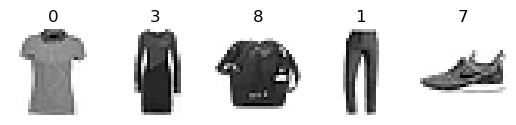

In [45]:
for X, y in train_set.take(1):
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(X[i].numpy(), cmap="binary")
        plt.axis("off")
        plt.title(str(y[i].numpy()))

In [47]:
class Standardization(keras.layers.Layer):
    def adapt(self, data_sample):
        self.means_ = np.mean(data_sample, axis=0, keepdims=True)
        self.stds_ = np.std(data_sample, axis=0, keepdims=True)
    def call(self, inputs):
        return (inputs - self.means_) / (self.stds_ + keras.backend.epsilon())

In [48]:
standardization = Standardization(input_shape=[28,28])

In [50]:
sample_image_batches = train_set.take(100).map(lambda image, label: image)
sample_images = np.concatenate(list(sample_image_batches.as_numpy_iterator()), 
                              axis=0).astype(np.float32)
standardization.adapt(sample_images)

In [51]:
model = keras.models.Sequential([
    standardization,
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
             metrics=["accuracy"])

In [52]:
from datetime import datetime
import os

logs = os.path.join(os.curdir, "my_logs", "run_" + datetime.now().strftime("%Y%m%d_%H%M%S"))

tensorboard_cb = keras.callbacks.TensorBoard(log_dir=logs, histogram_freq=1, profile_batch=10)

model.fit(train_set, epochs=5, validation_data=valid_set, callbacks=[tensorboard_cb])

Epoch 1/5


2024-01-11 22:51:00.202237: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-01-11 22:51:00.202265: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-01-11 22:51:00.203181: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.


     88/Unknown - 2s 2ms/step - loss: 0.8829 - accuracy: 0.7180

2024-01-11 22:51:01.666139: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-01-11 22:51:01.666171: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-01-11 22:51:01.669865: I tensorflow/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2024-01-11 22:51:01.677426: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2024-01-11 22:51:01.677781: I tensorflow/tsl/profiler/rpc/client/save_profile.cc:144] Collecting XSpace to repository: ./my_logs/run_20240111_225100/plugins/profile/2024_01_11_22_51_01/ubuntu.xplane.pb


1719/1719 [==============================] - 5s 2ms/step - loss: 0.4731 - accuracy: 0.8395 - val_loss: 0.4279 - val_accuracy: 0.8702
Epoch 2/5
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3488 - accuracy: 0.8784 - val_loss: 0.5630 - val_accuracy: 0.8576
Epoch 3/5
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3110 - accuracy: 0.8907 - val_loss: 0.4203 - val_accuracy: 0.8770
Epoch 4/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2843 - accuracy: 0.8987 - val_loss: 0.3877 - val_accuracy: 0.8816
Epoch 5/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2602 - accuracy: 0.9065 - val_loss: 0.4210 - val_accuracy: 0.8832
